## Titanic: Machine Learning from Disaster

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

We have structured the notebook in an intuitive way to the predictive modeling problem. We check existing features, only to add new features and some Machine Learning Concepts in data modelling.

### Contents of the Notebook <a class="anchor" id="toc"></a>

* [Exploratory Data Analysis](#f1)
    * [Gender vs Survival](#f1.1)
    * [Passenger Classes vs Survival](#f1.3)
    * [Initials vs Survival](#f1.4)
    * [Group/Family vs Survival](#f1.5)
    * [Fare vs Survival](#f1.6)
    * [Embarked vs Survival](#f1.7)
 
* [Handling Missing Values](#f2)
    * [Embarked:Missing Value](#f2.1)
    * [Age:Missing Value](#f2.2)
    * [Cabin:Missing Value](#f2.3)
* [Feature Engineering](#f3)

# Exploratory Data Analysis <a class="anchor" id="f1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

path = './input/'

data = pd.read_csv(path + 'train.csv')
data.shape

(891, 12)

In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


[Table of Contents](#toc)

## Gender vs Survival <a class="anchor" id="f1.1"></a>

In order to know if the gender of a person played an important role in the improving their survival rate, we plot the Survival vs Gender. 

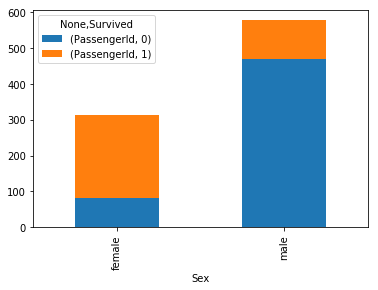

In [3]:
data[['PassengerId','Survived','Sex']].groupby(['Sex', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

#Most females survived while most males died. Correlation?

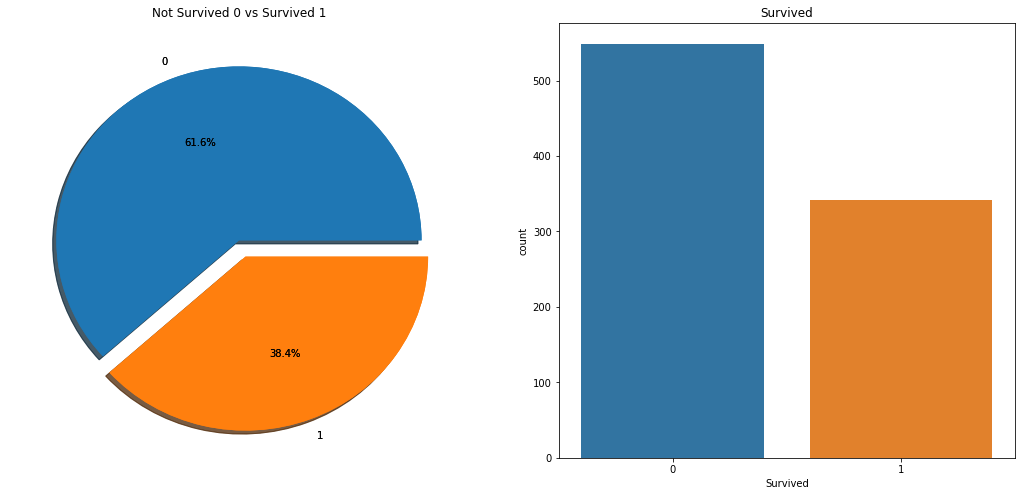

In [4]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
labels = ['Not Survived', 'Survived']
sizes = list(data['Survived'].value_counts())
explode = (0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Not Survived 0 vs Survived 1')
ax[0].set_ylabel('')

sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

In totality, we can see that the persons' gender does play a crucial role. We have to dig further to know the survival rate distribution.

[Table of Contents](#toc)

## Passenger Classes vs Survival <a class="anchor" id="f1.3"></a>

We need to know the exact population distribution across the different passenger classes, to see whether the passengers belonging to a particular class had a higher chance of surviving the fateful accident. 

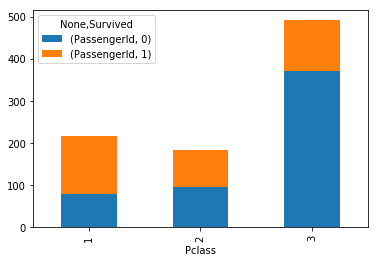

In [5]:
data[['PassengerId','Survived','Pclass']].groupby(['Pclass', 'Survived']).count().unstack().plot(kind='bar', stacked=True)
#People in higher classes survived more. Correlation?

In [6]:
pd.crosstab(data.Pclass,data.Survived,margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [ ]:
df=data[['PassengerId','Survived','Pclass']].groupby(['Survived','Pclass']).count()
f,ax=plt.subplots(1,2,figsize=(18,8))
df.plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,subplots=True)

sns.factorplot('Pclass','Survived',hue='Sex',data=data,ax=ax[1])
plt.show()

The pie chart shows that people belonging to Passenger class 3 did not survive, i.e more than two thirds of those that died belonged to Passenger Class 3.

In [ ]:
data[['PassengerId','Sex','Pclass']].groupby(['Pclass', 'Sex']).count().unstack().plot(kind='bar', stacked=True)

#More females in higher classes (1 and 2). What can we conclude? 
#Did females survive more because they were wealthy?
#Did wealthier people survive more because they had a high ratio of females?

In [ ]:
data[['PassengerId','Survived','Sex','Pclass']].groupby(['Sex', 'Pclass', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

#Class does seem to affect the survival rate

In [ ]:
data[['PassengerId','Survived','Sex','Pclass']].groupby(['Pclass', 'Sex', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

#Gender also seems to affect the survival rate

[Table of Contents](#toc)

## Initials vs Survival <a class="anchor" id="f1.4"></a>

We use the initials such as Col/Dr/Mme, etc. to understand the person's respectability in the society as subsequently, their survival characteristics.

In [ ]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.')

In [ ]:
pd.crosstab([data.Initial,data.Sex],[data.Survived])

We can see that married women (Mrs), small children(Miss/Master) had higher survival rate as compared to the rest. Also,the nobility, despite being outnumbered, did get a chance to survive.

[Table of Contents](#toc)

## Group/Family vs Survival <a class="anchor" id="f1.5"></a>

We need see whether those belonging to a family/group, were having higher chances of lifeboat.

In [ ]:
### Let's see if big families tend to survive more or less, or if it doesn't affect the survival
#Maybe families were given priority, or maybe having too many family members hindered the survival

df_sibsp = data[['PassengerId','Survived','SibSp']].groupby(['SibSp', 'Survived']).count()
df_sibsp.unstack().plot(kind='bar', stacked=True)

In [ ]:
def ratio(df, both = [], only_0 = [], only_1 = []):
    df.loc[:,'PassengerId'] = df.loc[:, 'PassengerId'].astype(float)
    for i in both:
        total = df.loc[(i,0),] + df.loc[(i,1),]
        df.loc[(i,0),] = df.loc[(i,0),]/total
        df.loc[(i,1),] = df.loc[(i,1),]/total
        total = 0
    for j in only_0:
        df.loc[(j,0),] = 1
    for k in only_1:
        df.loc[(j,1),] = 1
    return df

ratio(df_sibsp, range(5), [5,8]).unstack().plot(kind='bar', stacked=True)

In [ ]:
df_parch = data[['PassengerId','Survived','Parch']].groupby(['Parch', 'Survived']).count()
df_parch.unstack().plot(kind='bar', stacked=True)

In [ ]:
ratio(df_parch, [0,1,2,3,5], [4,6]).unstack().plot(kind='bar', stacked=True)

In [ ]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
df_famsize = data[['PassengerId','Survived','FamilySize']].groupby(['FamilySize', 'Survived']).count()
ratio(df_famsize, range(1,8), [8,11]).unstack().plot(kind='bar', stacked=True)

#We notice that small families have a higher survival rate, 
#while people who are alone or in a big family have a lower survival rate

In [ ]:
#Thus, it'd be more interesting to replace the quantitative FamilySize by a categorical value
#which would take value 0 if FamilySize(=1 or >4)
#and would take value 1 if 1<FamilySize<5

size = np.zeros(891)
for i in range(891):
    if(data.loc[i, 'FamilySize'] > 1 and data.loc[i, 'FamilySize'] < 4):
        size[i] = 1
data['Size'] = size

data[['PassengerId','Survived','Size']].groupby(['Size', 'Survived']).count().unstack().plot(kind='bar', stacked=True)

In [ ]:
#There's another way to evaluate a travelling group's size, even if they're not a family
#People travelling together are more likely to have bought the ticket together

ticket_count = data['Ticket'].value_counts()
data_ticket = pd.DataFrame(data={'ticket' : ticket_count.index.values, 'count' : ticket_count.values})

size_t = np.zeros(891)
for i in range(891):
    idx = data_ticket.index[data_ticket['ticket'] == data.loc[i, 'Ticket']].tolist()[0]
    size_t[i] = data_ticket.loc[idx, 'count']
data['Size_t'] = size_t

df_size_t = data[['PassengerId','Survived','Size_t']].groupby(['Size_t', 'Survived']).count()
df_size_t.unstack().plot(kind='bar', stacked=True)

In [ ]:
ratio(df_size_t, [1,2,3,4,7], [5,6]).unstack().plot(kind='bar', stacked=True)

#For this feature as well, a size between 2 and 4 is linked to a bigger chance of survival,
#Therefore using it would be redundant

[Table of Contents](#toc)

## Fare vs Survival <a class="anchor" id="f1.6"></a>

There is a saying that money can buy everything. Can it buy higher survivability?

In [ ]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

In [ ]:
data.boxplot('Fare', by='Pclass')

#The ticket fare seems to be highly correlated to the class.

In [ ]:
data.boxplot('Fare', by=['Pclass', 'Survived'])

#In the same class, a difference of ticket fare only seems to affect the survival rate for class 1
#In any case, rich people are more likely to survive 

#Conclusion : Keep or drop Fare/Pclass? Any new feature to extract?

In [ ]:
bins = [0, 1, 5, 10, 25, 50, 100, 200, 300, 400, 500, 600]
data['Farebin'] = pd.cut(data['Fare'], bins)
pd.crosstab([data.Farebin,data.Sex],[data.Survived])

df=data[['PassengerId','Survived','Farebin']].groupby(['Survived','Farebin']).count()
f,ax=plt.subplots(figsize=(10,10))
patches = df.plot.pie(autopct='%1.1f%%',ax=ax,shadow=True,subplots=True)
#list(patches)

[Table of Contents](#toc)

## Embarked vs Survival <a class="anchor" id="f1.7"></a>

We need to see whether there is a correlation between the boarding point and the survival chances. 

In [ ]:
df_emb = data[['PassengerId','Survived','Embarked']].groupby(['Embarked', 'Survived']).count()
df_emb.unstack().plot(kind='bar', stacked=True)

In [ ]:
ratio(df_emb, ['C', 'Q', 'S']).unstack().plot(kind='bar', stacked=True)

#It seems like for people who embarked at port C, the chance of survival is higher than for people
#who embarked at ports Q and S

In [ ]:
    f,ax=plt.subplots(2,2,figsize=(20,15))
    sns.countplot('Embarked',data=data,ax=ax[0,0])
    ax[0,0].set_title('No. Of Passengers Boarded')
    sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
    ax[0,1].set_title('Male-Female Split for Embarked')
    sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
    ax[1,0].set_title('Embarked vs Survived')
    sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
    ax[1,1].set_title('Embarked vs Pclass')
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    plt.show()

In [ ]:
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True)

In [ ]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

[Table of Contents](#toc)

## Handling Missing Values <a class="anchor" id="f2"></a>

In [ ]:
data_test = pd.read_csv(path + 'test.csv')

In [ ]:
for i in range(891):
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.')

In [ ]:
#Let's see if we have any missing values in our data

col_na = []
nb_na = np.zeros(data.shape[1])
for i in range(data.shape[1]):
    col_na.append(data.columns[i])
    nb_na[i] = data.iloc[:,i].isna().sum()
df_na = pd.DataFrame(col_na, nb_na)
df_na

#We need to find a way to fill Age, Cabin and Embarked

## Embarked:Missing Value <a class="anchor" id="f2.1"></a>

We use the most common boarding location to fill the missing values of Embarked column. 

In [ ]:
#Filling missing Embarked values
#If we can find another passanger with the same ticket, we can use their Embarked value to fill the NA

missing_emb = data.index[data['Embarked'].isna()].tolist()
#ticket = np.zeros(len(missing_emb))

#for i in range(len(missing_emb)):
#    for j in range(891):
#        if(j != missing_emb[i] and data.loc[j, 'Ticket'] == data.loc[missing_emb[i], 'Ticket']):
#            ticket[i] = data.loc[j, 'Ticket']

#data['Embarked'].fillna('S',inplace=True)
data.Embarked.isnull().any()# Finally No NaN values

In [ ]:
#data.index[data['Ticket'] == ticket[0]].tolist()

In [ ]:
#No one else has the same ticket, so the second best option is probably to fill the column
#with the most common value

data['Embarked'].value_counts()
sns.countplot('Embarked',data=data)

[Table of Contents](#toc)

## Age:Missing Value <a class="anchor" id="f2.2"></a>

We use the kNN algorithm to compute the missing age values. We use Pclass, Sex, SibSp and Initials.

In [ ]:
### To fill missing age, we can look for a relationship with other variables

data.boxplot('Age', by='Sex')

#Age is distributed differently for males and females

In [ ]:
data.boxplot('Age', by='Pclass')

#Age is distributed even more differently depending on class

In [ ]:
data.boxplot('Age', by='SibSp')

#Someone with a SibSp higher than 2 is travelling with siblings,
#it's more likely to be someone young travelling with their family

In [ ]:
data.boxplot('Age', by='Initial',autorange=True)

In [ ]:
data.Initial = pd.Categorical(data.Initial).codes
#data.Initial, mapping_index = pd.Series(data.Initial).factorize()
#data.head()

In [ ]:
data.replace('male', 0, inplace=True)
data.replace('female', 1, inplace=True)
data.tail()

In [ ]:
#We can try to fill the missing age values thanks to class and gender, using KNN

reg = KNeighborsRegressor(n_neighbors=3)
data_age = (data.loc[data['Age'].isna() == False]).iloc[:,[2,4,5,6,12]]
X_age = data_age[['Pclass','Sex','SibSp', 'Initial']]
y_age = data_age['Age']
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y_age, test_size=0.33)
reg.fit(X_age_train, y_age_train)
pred_age = reg.predict((data.loc[data['Age'].isna() == True]).iloc[:,[2,4,6,12]])
reg.score(X_age_test, y_age_test)

In [ ]:
data.boxplot('Age', by='Survived')

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='blue')
ax[0].set_title('Did Not Survive')
ax[0].set_xlabel('Age Group')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='orange',bins=20,edgecolor='black')
ax[1].set_title('Survived')
ax[1].set_xlabel('Age Group')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

To conclude, there were 3 age groups that had a higher chance of survival.
    1. Toddlers (0-5 yrs)
    2. Teenagers (15-20 yrs)
    3. Elderly (75 yrs above)
    
[Table of Contents](#toc)

## Cabin:Missing Value <a class="anchor" id="f2.3"></a>

In [ ]:
### Missing values for cabin

data[['PassengerId', 'Pclass']].where(data['Cabin'].isna()).groupby(['Pclass']).count()
sns.countplot('Pclass',data=data.where(data['Cabin'].isna()))

In [ ]:
data[['PassengerId', 'Pclass']].groupby(['Pclass']).count()

#Cabin seems to only be interesting for passengers of the class 1, which are a minority

In [ ]:
#location = []
#for i in range(891):
#    if(isinstance(data.loc[i, 'Cabin'], str)):
#        location.append(data.loc[i, 'Cabin'][0])
#    else:
#        location.append(np.nan)
#data['Location'] = location

[Table of Contents](#toc)

## Feature Engineering  <a class="anchor" id="f3"></a>

In [ ]:
#We can replace this feature with a 0 for ports Q and S, and 1 for port C

data.replace('C', 1, inplace=True)
data.replace('Q', 0, inplace=True)
data.replace('S', 0, inplace=True)

In [ ]:
### This should be the final line of code
### It generates a clean csv to be used for training our models

data[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Size', 'Embarked']].to_csv('./cleanData/train.csv')